In [35]:
# ======================================
# 📦 Libraries
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Sklearn Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score


In [36]:
# ======================================
# 📥 Daten laden & Übersicht
# ======================================
df = pd.read_csv("data/airline_review.csv")  # Pfad ggf. anpassen

print("📊 Shape:", df.shape)
print("🧾 Spalten:\n", df.columns.tolist())
print("\n🔍 Vorschau:")
display(df.head())

📊 Shape: (23171, 20)
🧾 Spalten:
 ['Unnamed: 0', 'Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date', 'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended']

🔍 Vorschau:


,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


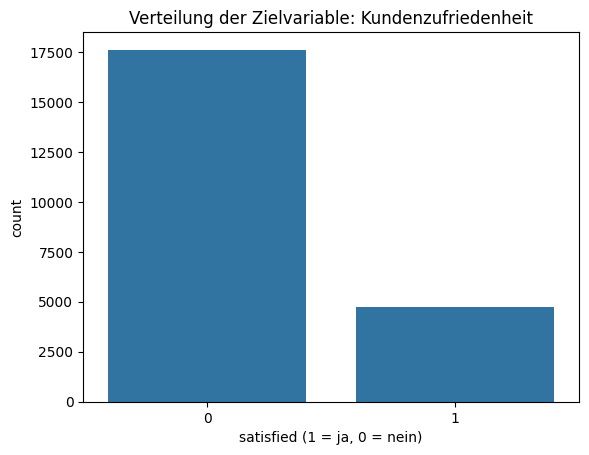

In [37]:
# ======================================
# 🧼 Preprocessing – Zielvariable & Feature Cleanup
# ======================================

# Overall Rating in numerisch umwandeln (z. B. '9' → 9.0)
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')

# Fehlende Bewertungen entfernen
df = df.dropna(subset=['Overall_Rating'])

# Zielvariable definieren: 1 = zufrieden (>=7), 0 = unzufrieden
df['satisfied'] = df['Overall_Rating'].apply(lambda x: 1 if x >= 7 else 0)

# Übersicht der Verteilung
sns.countplot(data=df, x='satisfied')
plt.title("Verteilung der Zielvariable: Kundenzufriedenheit")
plt.xlabel("satisfied (1 = ja, 0 = nein)")
plt.show()

In [38]:
# ======================================
# 🧪 Feature Engineering & Encoding
# ======================================

# Alle kategorischen Spalten erkennen
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Label-Encoding für Kategorien
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Features definieren (nicht: Rating + Ziel)
drop_cols = [
    'Overall_Rating', 'satisfied',
    'Unnamed: 0', 'Review', 'Review_Title', 'Review Date', 'Date Flown'
]
features = df.drop(columns=drop_cols, errors='ignore')
target = df['satisfied']

print("🧠 Input Features:", features.columns.tolist())
print("📊 Feature-Matrix Shape:", features.shape)

🧠 Input Features: ['Airline Name', 'Verified', 'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended']
📊 Feature-Matrix Shape: (22329, 14)


In [39]:
# ======================================
# 🔀 Train-Test Split + Skalierung
# ======================================
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# ======================================
# 🤖 Modelltraining & Evaluation
# ======================================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

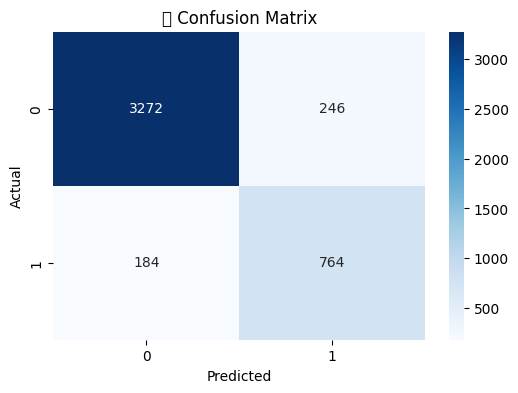

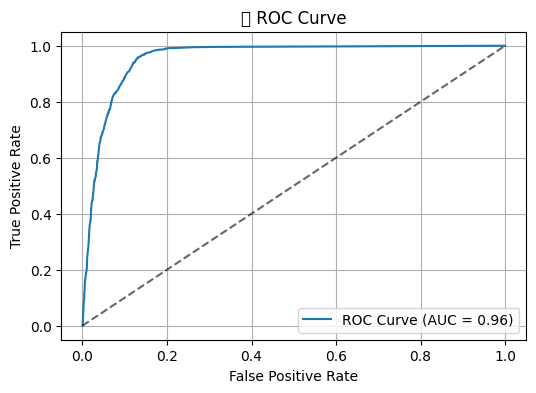

📢 Recall (unzufriedene Kunden erkannt): 0.93


In [41]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("🧮 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🎯 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Recall speziell für unzufriedene Kunden
recall_unzufrieden = recall_score(y_test, y_pred, pos_label=0)
print(f"📢 Recall (unzufriedene Kunden erkannt): {recall_unzufrieden:.2f}")

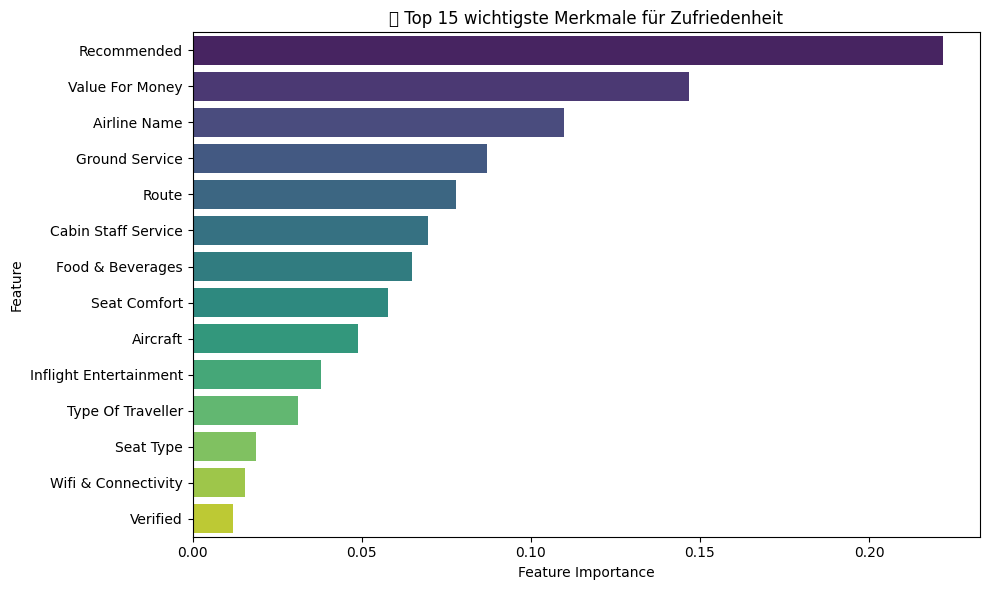

In [42]:
# ======================================
# 📊 Feature Importance
# ======================================
importances = model.feature_importances_
feat_names = features.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot Top N Features
plt.figure(figsize=(10,6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔥 Top 15 wichtigste Merkmale für Zufriedenheit")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Zielvariable: Zufriedenheitsscore statt Klassifikation
target = df['Overall_Rating']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Skalieren (optional für Bäume, empfohlen für andere Modelle)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modell
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)  # ✅ Modelltraining

# Vorhersage
y_pred = model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.2f}")

📉 RMSE: 1.82
📊 MAE: 1.12
📈 R² Score: 0.60


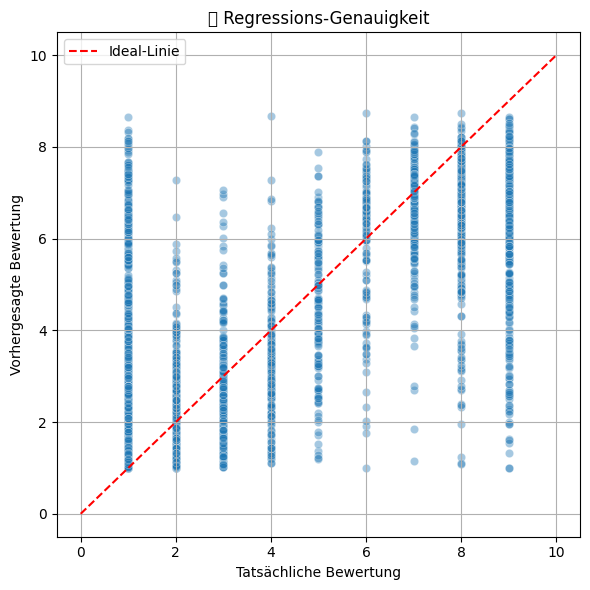

In [49]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([0,10], [0,10], 'r--', label='Ideal-Linie')
plt.xlabel("Tatsächliche Bewertung")
plt.ylabel("Vorhergesagte Bewertung")
plt.title("🔍 Regressions-Genauigkeit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()